In [1]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [24]:
pd.set_option('display.max_rows', None)
AWpropleak = pd.read_csv('Prop Leak Data.csv')
AWpropleak['Date Fixed'] = pd.to_datetime(AWpropleak['Date Fixed'])
AWpropleak['Date Fixed'].isna().sum()
AWpropleak = AWpropleak.dropna(subset = ['Date Fixed'])
print(AWpropleak.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4101 entries, 0 to 4821
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unique Ref          4101 non-null   object        
 1   Date Leak Start     4101 non-null   object        
 2   Flow L/hr at Start  4101 non-null   int64         
 3   Peak Flow date      4101 non-null   object        
 4   Peak Flow           4101 non-null   int64         
 5   Date Fixed          4101 non-null   datetime64[ns]
 6   Leak Location       4101 non-null   object        
 7   Internal Leak Type  4101 non-null   object        
 8   Toilet Type         4101 non-null   object        
 9   External leak type  4101 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 352.4+ KB
None


In [25]:
AWpropleak['Unique Ref'].value_counts().head()

7E03A861-9F99-4B6C-9897-8881FA9CDED5    4
BCC11DA4-C8DD-4C6D-899D-DE44D2A35CFF    4
E2D12403-56C1-4621-AEC9-68B776F2BB39    4
58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C    4
E9038E62-F2A6-44F4-9BC5-961D9EDDAC75    4
Name: Unique Ref, dtype: int64

Only focusing on (1) smart meter that showed a high frequency (4) of leakage between 2016 and 2020.

In [6]:
path = r'C:\Users\vt135\OneDrive\Documents\Water Consumption Hackathon\Top_num_leakage' # path
all_files = glob.glob(path + "/*.txt")
list_of_dfs = [pd.read_csv(filename) for filename in all_files]
for dataframe, filename in zip(list_of_dfs, all_files):
    dataframe['filename'] = filename
combined_df = pd.concat(list_of_dfs, ignore_index=True)
combined_df['filename'] = combined_df['filename'].str[len(r'C:\Users\vt135\OneDrive\Documents\Water Consumption Hackathon\Top_num_leakage')+1:-4]
combined_df['time'] = pd.to_datetime(combined_df['time'])
combined_df = combined_df.set_index('time')
combined_df = combined_df.drop(['cons_cor'], axis =1)
combined_df.head()

,cons,filename
time,,
2016-12-05 02:00:00,0,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C
2016-12-05 03:00:00,3,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C
2016-12-05 04:00:00,0,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C
2016-12-05 05:00:00,0,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C
2016-12-05 06:00:00,4,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C


Only selecting night time consumption (2:00-4:00 am) to more easily determine flows considered leaks by property without daily noises. Resampling by minimum between time window for the purpose of selecting threshhold of anomaly (see ML model below).

In [14]:
df_0204 = combined_df.between_time('02:00:00', '04:00:00')
df1 = df_0204.groupby('filename')['cons'].resample('1D').min()
df1 = pd.DataFrame(df1).dropna()
df1.reset_index(inplace = True)
df1.head()

,filename,time,cons
0,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C,2016-12-05,0.0
1,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C,2016-12-07,0.0
2,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C,2016-12-14,0.0
3,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C,2016-12-15,0.0
4,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C,2016-12-16,0.0


For the selected meter (filename), looking at a 180-day profile before and after a leak instance is recorded as fixed to understand values corresponding to leaks at the property.

In [26]:
def cons_variation():
    output = []
    for index, row in AWpropleak.iterrows():
        meter_name = row['Unique Ref']
        subset_df1 = df1[df1['filename'] == meter_name].reset_index()
        if subset_df1.empty:
            continue

        fixed_date = row['Date Fixed']
        subset_df1_unique = subset_df1.filename.unique()
       
        for i in subset_df1_unique:
            for idx2, row2 in subset_df1.iterrows():
                if i == row2['filename'] and abs((row2['time'] - fixed_date).days) <= 180:
                    output.append(row2)
    output = pd.DataFrame(output)
        
    return output

cons_variation().head()

,index,filename,time,cons
31,31,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C,2017-01-12,0.0
32,32,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C,2017-01-13,0.0
33,33,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C,2017-01-14,0.0
34,34,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C,2017-01-15,0.0
35,35,58BE48EF-0AB6-41D3-ACE4-D91F9C1ACE7C,2017-01-16,0.0


In [27]:
prop = AWpropleak[AWpropleak['Unique Ref'] == 'BCC11DA4-C8DD-4C6D-899D-DE44D2A35CFF']
prop

,Unique Ref,Date Leak Start,Flow L/hr at Start,Peak Flow date,Peak Flow,Date Fixed,Leak Location,Internal Leak Type,Toilet Type,External leak type
399,BCC11DA4-C8DD-4C6D-899D-DE44D2A35CFF,7/6/2017,24,8/8/2017,26,2017-08-09,Internal,Tank,_,_
2463,BCC11DA4-C8DD-4C6D-899D-DE44D2A35CFF,6/9/2019,3,10/1/2019,168,2019-10-02,Unknown,_,_,_
3335,BCC11DA4-C8DD-4C6D-899D-DE44D2A35CFF,11/4/2019,1,12/18/2019,177,2020-01-07,Unknown,_,_,_
4542,BCC11DA4-C8DD-4C6D-899D-DE44D2A35CFF,6/2/2020,9,6/15/2020,16,2020-06-30,Unknown,_,_,_


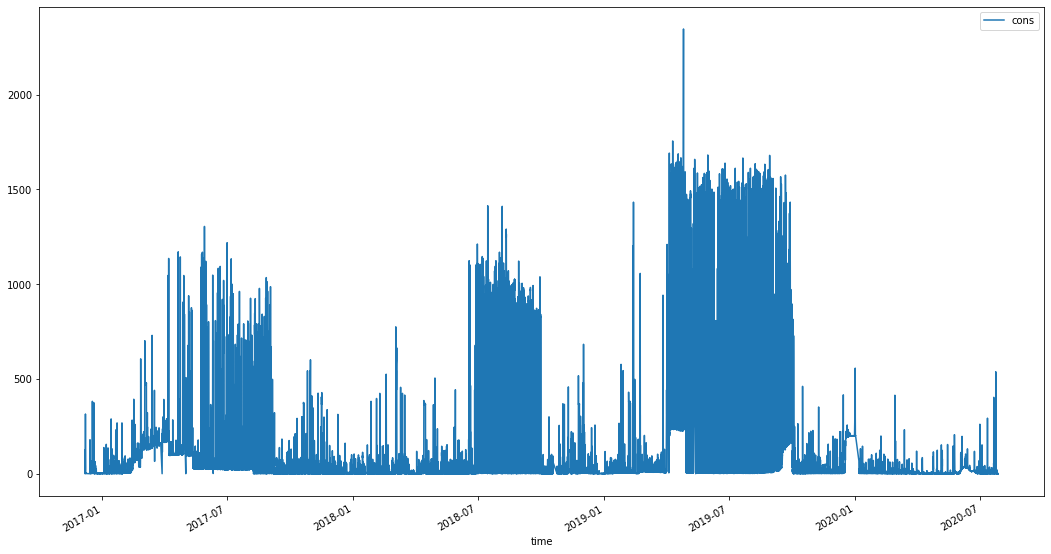

In [28]:
df_mod = combined_df[combined_df['filename'] == 'BCC11DA4-C8DD-4C6D-899D-DE44D2A35CFF']
df_mod = df_mod.drop(['filename'], axis = 1)
df_mod = df_mod.reset_index()
df_mod.plot(x='time', y='cons', figsize=(18,10))


In [29]:
import plotly.graph_objects as go

df4_leak1 = df_mod[df_mod["time"].isin(pd.date_range('2017-06-07', '2017-08-09'))]
df4_leak2 = df_mod[df_mod["time"].isin(pd.date_range('2019-09-06', '2019-10-02'))]
df4_leak3 = df_mod[df_mod["time"].isin(pd.date_range('2019-11-04', '2020-01-07'))]
df4_leak4 = df_mod[df_mod["time"].isin(pd.date_range('2020-06-02', '2020-06-30'))]
df4_leak = pd.concat([df4_leak1, df4_leak2, df4_leak3, df4_leak4])
fig = go.Figure()
fig.add_trace(go.Scatter(x= df_mod['time'], y=df_mod['cons'], mode = 'lines', name = 'normal(occasionally suspicious)'))
fig.add_trace(go.Scatter(x= df4_leak1['time'], y=df4_leak1['cons'], mode = 'lines', name = '1st leak'))
fig.add_trace(go.Scatter(x= df4_leak2['time'], y=df4_leak2['cons'], mode = 'lines', name = '2nd leak'))
fig.add_trace(go.Scatter(x= df4_leak3['time'], y=df4_leak1['cons'], mode = 'lines', name = '3rd leak'))
fig.add_trace(go.Scatter(x= df4_leak4['time'], y=df4_leak4['cons'], mode = 'lines', name = '4th leak'))

fig.update_layout(title='Supposedly Normal night consumption vs night line leakage',
                   xaxis_title='Date',
                   yaxis_title='Consumption(L/hr)')

fig.show()

Selection of water meter is based on meter showing the most delineation between what constitutes leak and normal consumption.

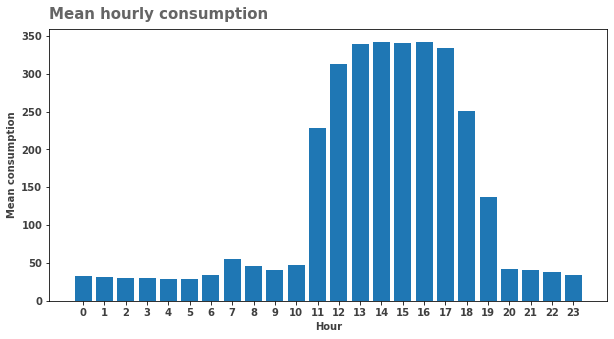

In [11]:
df_mod.index = df_mod['time']
df_mod['Hour'] = df_mod['time'].dt.hour
mean_per_hour = df_mod.groupby("Hour")["cons"].agg(["mean"])

#Plot
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(mean_per_hour.index, mean_per_hour["mean"])

plt.xticks(range(24),alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Hour",alpha=0.75, weight="bold")
plt.ylabel("Mean consumption",alpha=0.75, weight="bold")

plt.title("Mean hourly consumption", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

del mean_per_hour

Fit LSTM model

In [12]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, RepeatVector, LSTM, TimeDistributed
from tensorflow.keras.models import Sequential
import seaborn as sns

In [13]:

train_size = int(len(df_mod)*0.80)
test_size = len(df_mod) - train_size
train, test = df_mod.iloc[0:train_size], df_mod.iloc[train_size:len(df_mod)]
print(train.shape, test.shape)


(25761, 3) (6441, 3)


In [14]:
scaler = StandardScaler()
scaler = scaler.fit(train[['cons']])
train['cons'] = scaler.transform(train[['cons']])
test['cons'] = scaler.transform(test[['cons']])

C:\Users\vt135\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vt135\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [16]:
TIME_STEPS = 720 # (1 month of hourly data sequence)
X_train, y_train = create_dataset(train[['cons']], train.cons, TIME_STEPS)
X_test, y_test = create_dataset(test[['cons']], test.cons, TIME_STEPS)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25041, 720, 1) (25041,) (5721, 720, 1) (5721,)


In [17]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=100, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(
    units=200,
    return_sequences=True
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(
    units=X_train.shape[2]
)))
model.compile(loss='mae', optimizer='adam')

In [18]:
history = model.fit(
    X_train, y_train,
    epochs = 10,
    batch_size = 100,
    validation_split = 0.1,
    shuffle = False
)

Epoch 1/10
226/226 [==============================] - 2253s 10s/step - loss: 0.1940 - val_loss: 0.3309
Epoch 2/10
226/226 [==============================] - 2489s 11s/step - loss: 0.1657 - val_loss: 0.2877
Epoch 3/10
226/226 [==============================] - 2419s 11s/step - loss: 0.1507 - val_loss: 0.3024
Epoch 4/10
226/226 [==============================] - 2611s 12s/step - loss: 0.1484 - val_loss: 0.2973
Epoch 5/10
226/226 [==============================] - 2432s 11s/step - loss: 0.1474 - val_loss: 0.2850
Epoch 6/10
226/226 [==============================] - 2633s 12s/step - loss: 0.1459 - val_loss: 0.3114
Epoch 7/10
226/226 [==============================] - 2442s 11s/step - loss: 0.1456 - val_loss: 0.2917
Epoch 8/10
226/226 [==============================] - 2453s 11s/step - loss: 0.1454 - val_loss: 0.2913
Epoch 9/10
226/226 [==============================] - 2475s 11s/step - loss: 0.1445 - val_loss: 0.2902
Epoch 10/10
226/226 [==============================] - 2499s 11s/step - l

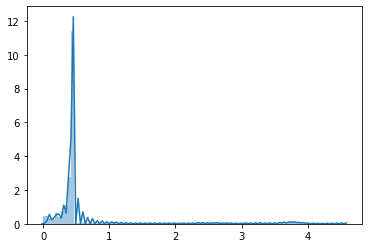

In [20]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred, X_train), axis = 1)
sns.distplot(train_mae_loss, bins = 100, kde = True);

In [21]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred, X_test), axis = 1)

In [22]:
THRESHOLD = 0.5
test_score_dfmod = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_dfmod['loss'] = test_mae_loss
test_score_dfmod['threshold'] = THRESHOLD
test_score_dfmod['anomaly'] = test_score_dfmod.loss > test_score_dfmod.threshold
test_score_dfmod['cons'] = test[TIME_STEPS:].cons

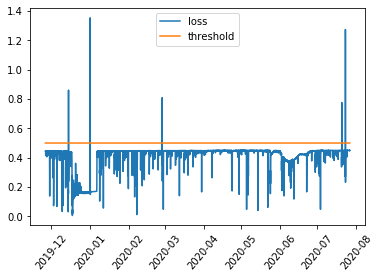

In [23]:
plt.plot(test_score_dfmod.index, test_score_dfmod.loss, label = 'loss')
plt.plot(test_score_dfmod.index, test_score_dfmod.threshold, label='threshold')
plt.xticks(rotation=50)
plt.legend();

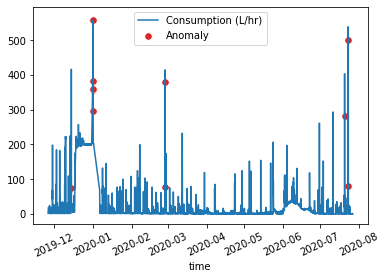

In [24]:
anomalies = test_score_dfmod[test_score_dfmod.anomaly == True]
plt.plot(
    test[TIME_STEPS:].index,
    scaler.inverse_transform(test[TIME_STEPS:].cons),
    label = 'Consumption (L/hr)'
);
sns.scatterplot(
    anomalies.index,
    scaler.inverse_transform(anomalies.cons),
    color = sns.color_palette()[3],
    s = 55,
    label = 'Anomaly'
)
plt.xticks(rotation = 25)
plt.legend();


The model is tailored to detect anomaly events that correspond to high water leaks (i.e. pipe burst) rather than water drips at the selected customer property.